In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import interp
%matplotlib inline

# Set random seed to ensure reproducability
random_state = 42

In [3]:
# Column names extracted from the dataset description file
cols = ["Elevation", "Aspect", "Slope", "Horizontal_Distance_To_Hydrology", 
         "Vertical_Distance_To_Hydrology", "Horizontal_Distance_To_Roadways", 
         "Hillshade_9am", "Hillshade_Noon", "Hillshade_3pm", 
         "Horizontal_Distance_To_Fire_Points"] + \
       ["Wilderness_Area_{}".format(i) for i in range(4)] + \
       ["Soil_Type {}".format(i) for i in range(40)] + \
       ["Cover_Type"]

In [4]:
data = pd.read_csv('dataset/covtype.data', header=None, names=cols)

# Data preparation
- **subsample the data to 10k samples**

In [5]:
class_size = 10000
df = data.groupby("Cover_Type").apply(lambda x: x.sample(min(class_size, len(x)))).reset_index(1)
df = df.drop(columns=["Cover_Type"]).reset_index().drop(columns=["level_1"])

X = df.loc[:, df.columns != 'Cover_Type']
y = df[["Cover_Type"]]

### Get the binary columns

In [6]:
binary_columns = df.columns[df.columns.map(lambda x: ("Area" in x) or ("Soil" in x))]
binX = X.loc[:, binary_columns]

### Get the numeric columns

In [7]:
numeric_columns = ["Elevation", "Aspect", "Slope", "Horizontal_Distance_To_Hydrology", 
         "Vertical_Distance_To_Hydrology", "Horizontal_Distance_To_Roadways", 
         "Hillshade_9am", "Hillshade_Noon", "Hillshade_3pm", 
         "Horizontal_Distance_To_Fire_Points"]
numX = X.loc[:, numeric_columns]
numX = pd.concat([numX, y], axis=1)

In [8]:
dumX = pd.DataFrame()

for col in numX:
    cutdf = pd.cut(numX[col], 3, labels=[0, 1, 2])
    dummydf = pd.get_dummies(cutdf)
    seriesname = dummydf.columns.name
    dummydf.columns = [seriesname + "_low", seriesname + "_mid", seriesname + "_high"]
    dumX = pd.concat([dumX, dummydf], axis=1)

In [9]:
print("Shape of the dummyfied dataset:", dumX.shape)
print("Shape of the binary dataset: ", binX.shape)

Shape of the dummyfied dataset: (62240, 33)
Shape of the binary dataset:  (62240, 44)


In [10]:
allX = pd.concat([dumX, binX], axis=1)

# Unsupervised learning

## Association rules

In [11]:
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.preprocessing import LabelBinarizer

frequent_itemsets = {}
minpaterns = 10
minsup = 0.9
classrules = None
while minsup > 0:    
    minsup = minsup * 0.9
    frequent_itemsets = apriori(allX, min_support=minsup, use_colnames=True, verbose=3)
    
    if len(frequent_itemsets) < 1:
        continue
    
    frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.7)
    classrules = rules[rules['consequents'] == {'Cover_Type'}]
    
    print("Minsup {} found {} patterns out of which {} contain class consequent"
          .format(minsup, len(frequent_itemsets), len(classrules)))  
    
    if len(classrules) >= 100:
        print("Found {} rules which have Cover_Type as consequent.".format(len(classrules)))
        break;
    
    if len(frequent_itemsets) >= minpaterns:
        print("Minimum support:", minsup)
        print("Number of found patterns:", len(frequent_itemsets))
        break

Processing 6 combinations | Sampling itemset size 2
Minsup 0.81 found 4 patterns out of which 0 contain class consequent
Processing 3 combinations | Sampling itemset size 3
Minsup 0.7290000000000001 found 9 patterns out of which 0 contain class consequent
Processing 39 combinations | Sampling itemset size 3
Minsup 0.6561000000000001 found 20 patterns out of which 0 contain class consequent
Minimum support: 0.6561000000000001
Number of found patterns: 20


$$\text{Workflow of getting the rules into }\LaTeX$$
1. Generate this csv as shown below
2. Copy it to the https://www.tablesgenerator.com/latex_tables and under File->Paste table data paste the data
3. Copy the data to the Latex
4. Replace "-" with \\ to do the line breaks
5. Style the table and resize it correctly

In [12]:
select = rules
select = select.sort_values(by=["confidence", "support", "leverage"], ascending=False)\
    [["antecedents", "consequents", "confidence", "support", "leverage"]].head(5).round(3)

select = select.rename(columns={"confidence": "conf", "support": "supp", "leverage": "lever"})
print(select.to_csv(index=False, sep=";").replace("frozenset({", "").replace("})", "").replace("'", "")\
     .replace(", ", "-"))

antecedents;consequents;conf;supp;lever
Slope_low;Hillshade_Noon_high;1.0;0.673;0.055
Hillshade_9am_high-Slope_low;Hillshade_Noon_high;1.0;0.665;0.054
Slope_low;Hillshade_Noon_high-Hillshade_9am_high;0.987;0.665;0.109
Slope_low;Hillshade_9am_high;0.987;0.665;0.065
Hillshade_Noon_high-Slope_low;Hillshade_9am_high;0.987;0.665;0.065



## Clustering
- include the silhouette analysis
- whatever score
- contingency matrix

### Subsample the data even more

In [30]:
class_size = 500
df = data.groupby("Cover_Type").apply(lambda x: x.sample(min(class_size, len(x)))).reset_index(1)
df = df.drop(columns=["Cover_Type"]).reset_index().drop(columns=["level_1"])

X = df.loc[:, df.columns != 'Cover_Type']
y = df[["Cover_Type"]]

### Standardize the numerical attribs
>Standardizing data is recommended because otherwise the range of values in each feature will act as a weight when determining how to cluster data, which is typically undesired.

In [31]:
binary_columns = X.columns[X.columns.map(lambda x: ("Area" in x) or ("Soil" in x))]
numeric_columns = ["Elevation", "Aspect", "Slope", "Horizontal_Distance_To_Hydrology", 
         "Vertical_Distance_To_Hydrology", "Horizontal_Distance_To_Roadways", 
         "Hillshade_9am", "Hillshade_Noon", "Hillshade_3pm", 
         "Horizontal_Distance_To_Fire_Points"]

binX = X.loc[:, binary_columns]
numX = X.loc[:, numeric_columns]

In [32]:
from sklearn.preprocessing import StandardScaler

nX = pd.DataFrame(StandardScaler().fit_transform(numX), columns=numX.columns)

In [33]:
cdf = pd.concat([binX, numX], axis=1)

### Agglomerative clustering

In [34]:
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import KMeans

def dendrogram_plot(data, link="single", metric="euclidean"):
    linkageMatrix = linkage(data, link, metric=metric)

    plt.xlabel('point index')
    plt.ylabel('distance')
    dendrogram(linkageMatrix, truncate_mode='lastp', p=64,
        leaf_rotation=90., leaf_font_size=8.)

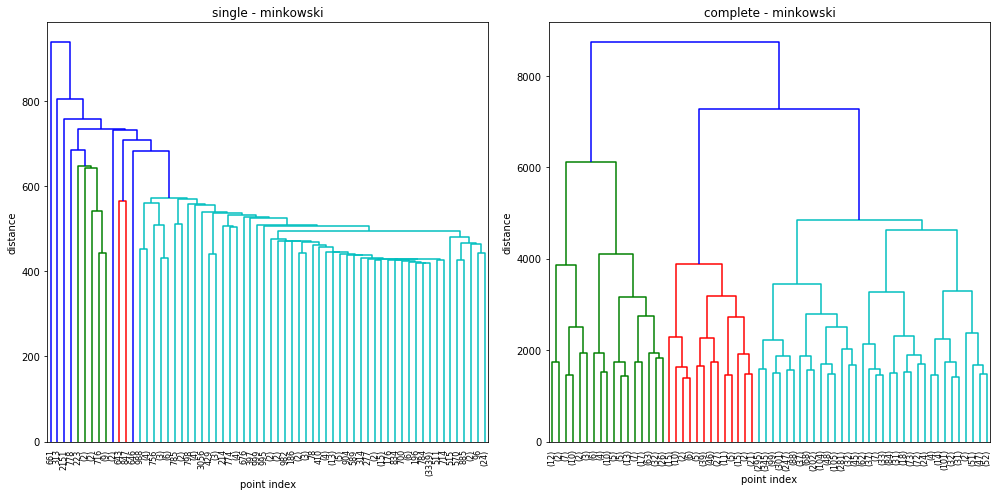

In [35]:
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.title("single - minkowski")
dendrogram_plot(cdf, "single", "minkowski")
plt.subplot(1, 2, 2)
plt.title("complete - minkowski")
dendrogram_plot(cdf, "complete", "minkowski")
plt.tight_layout()
plt.show()

In [163]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import fcluster
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

linkageMatrix = linkage(cdf, "complete", metric="minkowski")
clusters = fcluster(linkageMatrix, 7, criterion='maxclust')

# Save the cluster number to the standardized dataset
clustered = cdf.copy()
clustered["cluster"] = clusters

# Generate a different color for each cluster
cm = matplotlib.cm.get_cmap("viridis")
colors = cm(np.linspace(0, 1, len(np.unique(clusters))))

# Reduce the dimensionality to 2D and plot the clusters.
transformed = PCA(n_components=2).fit_transform(clustered.drop(columns=["cluster"]))
transformed = pd.DataFrame(transformed, columns=["x", "y"])
transformed["class"] = y
transformed["cluster"] = clusters
transformed["color"] = transformed.cluster.apply(lambda x: colors[x-1])

transformedS = TSNE(n_components=2).fit_transform(clustered.drop(columns=["cluster"]))
transformedS = pd.DataFrame(transformedS, columns=["x", "y"])
transformedS["class"] = y
transformedS["cluster"] = clusters
transformedS["color"] = transformedS.cluster.apply(lambda x: colors[x-1])

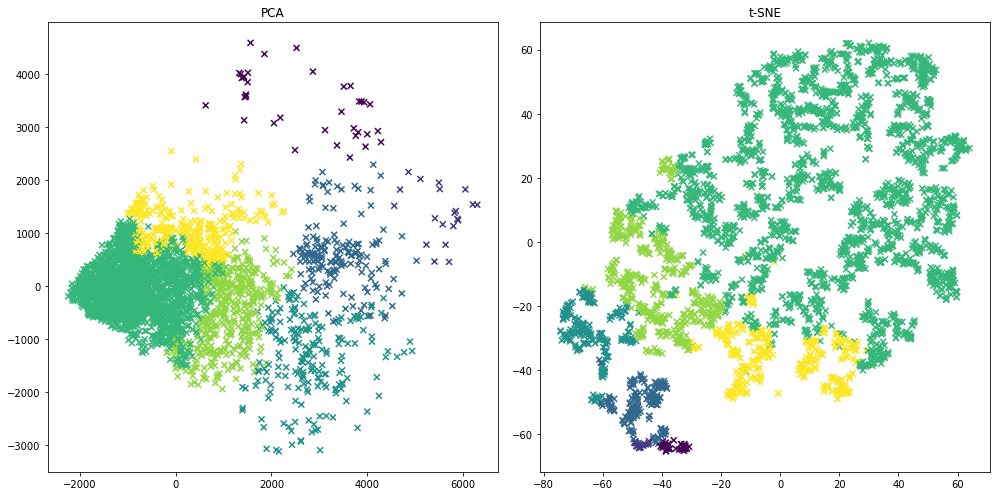

In [164]:
# Plot the clusters with different colors
plt.figure(figsize=(14, 7))
ax = plt.subplot(1, 2, 1)
plt.title("PCA")
plt.scatter(transformed.x, transformed.y, c=transformed.color, marker="x")
ax = plt.subplot(1, 2, 2)
plt.title("t-SNE")
plt.scatter(transformedS.x, transformedS.y, c=transformedS.color, marker="x")
plt.tight_layout()
plt.show()

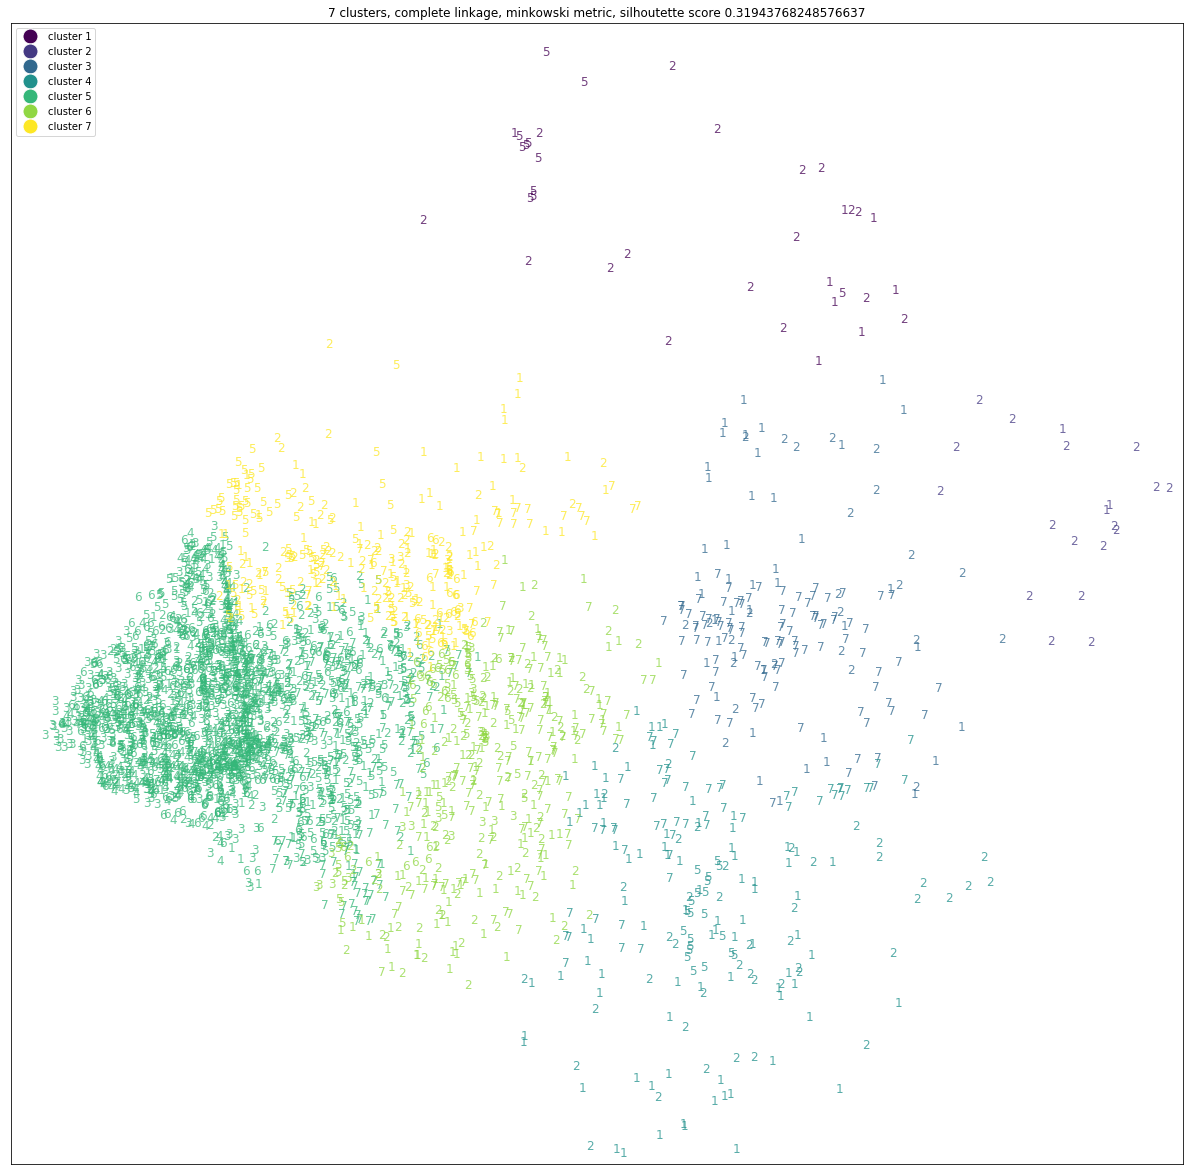

In [165]:
from sklearn.metrics import silhouette_score
from matplotlib.lines import Line2D


# Calculate the silhouette score
score = silhouette_score(cdf, clusters)

fig, ax = plt.subplots(figsize=(21, 21))
ax.set_xlim(-2500, 6400)
ax.set_ylim(-3200, 4800)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("7 clusters, complete linkage, minkowski metric, silhoutette score " + str(score))

#loop through labels and plot each cluster
for i, label in enumerate(np.unique(clusters)):
    for l, row in transformed.loc[transformed['cluster']==label,:].iterrows():
        plt.annotate(row['class'], 
                     (row['x'], row['y']),
                     horizontalalignment='center',
                     verticalalignment='center',
                     size=12,
                     color=row["color"], alpha=0.75) 
        
        
legend_elements = []
for c in np.unique(clusters):
    color = colors[c-1]
    legend_elements.append(\
        Line2D([0], [0], marker='o', color="w", label=("cluster " + str(c)), 
               markerfacecolor=color ,markersize=15)
    )
         
plt.legend(handles=legend_elements, loc="upper left")
plt.show()

### KMeans clustering

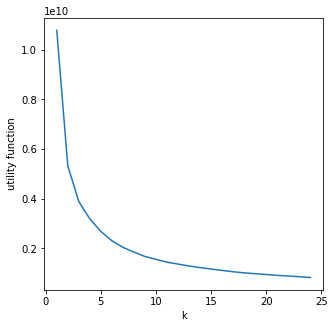

In [166]:
def elbow_plot(data):
    inertia = []
    for i in range(1,25):
        kmeans = KMeans(n_clusters=i, random_state=420)
        kmeans.fit(data)
        inertia.append(kmeans.inertia_)

    # Plot the elbow graph
    plt.plot(range(1,25), inertia)
    plt.xlabel("k")
    plt.ylabel('utility function')
    return plt

plt.figure(figsize=(5, 5))
elbow1 = elbow_plot(cdf)
plt.show()

In [168]:
clusters = KMeans(n_clusters=7, init='k-means++', random_state=420).fit_predict(cdf)
transformedK = PCA(n_components=2).fit_transform(cdf)

colors = cm(np.linspace(0, 1, len(np.unique(clusters))))
transformedK = pd.DataFrame(transformedK, columns=["x", "y"])
transformedK["class"] = y.values
transformedK["cluster"] = clusters
transformedK["color"] = transformedK.cluster.apply(lambda x: colors[x-1])

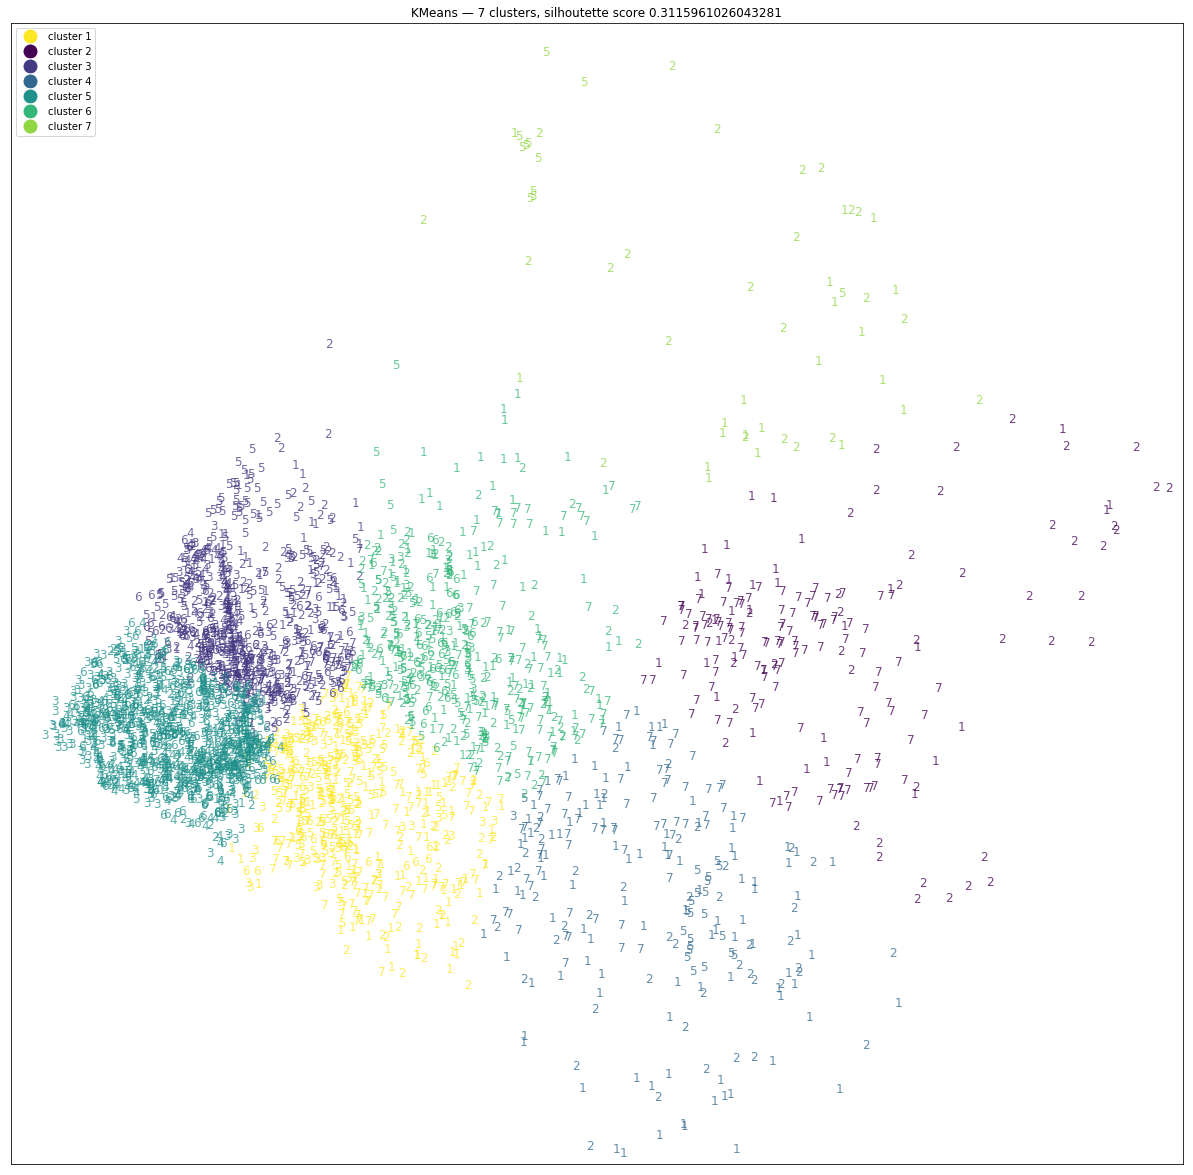

In [169]:
from sklearn.metrics import silhouette_score
from matplotlib.lines import Line2D

# Calculate the silhouette score
score = silhouette_score(cdf, clusters)

fig, ax = plt.subplots(figsize=(21, 21))
ax.set_xlim(-2500, 6400)
ax.set_ylim(-3200, 4800)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("KMeans — 7 clusters, silhoutette score " + str(score))

#loop through labels and plot each cluster
for i, label in enumerate(np.unique(clusters)):
    for l, row in transformedK.loc[transformedK['cluster']==label,:].iterrows():
        plt.annotate(row['class'], 
                     (row['x'], row['y']),
                     horizontalalignment='center',
                     verticalalignment='center',
                     size=12,
                     color=row["color"], alpha=0.75) 
        
        
legend_elements = []
for c in np.unique(clusters):
    color = colors[c-1]
    legend_elements.append(\
        Line2D([0], [0], marker='o', color="w", label=("cluster " + str(c+1)), 
               markerfacecolor=color ,markersize=15)
    )
         
plt.legend(handles=legend_elements, loc="upper left")
plt.show()

In [173]:
targetnames = {
    1: "Spruce/Fir",
    2: "Lodgepole Pine",
    3: "Ponderosa Pine",
    4: "Cottonwood/Willow",
    5: "Aspen",
    6: "Douglas-fir",
    7: "Krummholz"
}

# kmeans
transformedK["classname"] = transformedK["class"].apply(lambda x: targetnames[x])

# aglomerative
transformed["classname"] = transformed["class"].apply(lambda x: targetnames[x])

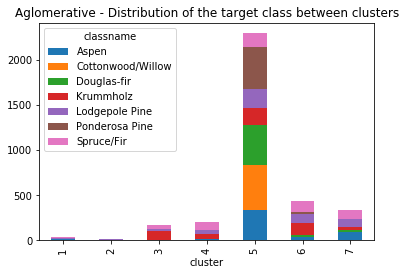

In [176]:
ax = transformed.groupby(by=["cluster", "classname"]).count().color.unstack().fillna(0).plot(kind="bar", stacked=True)
ax.set_title("Aglomerative - Distribution of the target class between clusters")
plt.show()

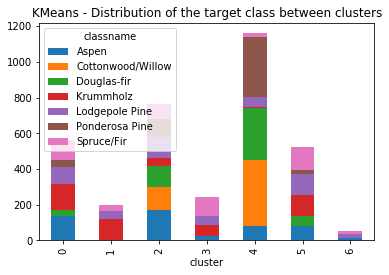

In [174]:
ax = transformedK.groupby(by=["cluster", "classname"]).count().color.unstack().fillna(0).plot(kind="bar", stacked=True)
ax.set_title("KMeans - Distribution of the target class between clusters")
plt.show()